In [0]:
!git clone https://github.com/pruvi007/ML_Datasets.git

Cloning into 'ML_Datasets'...
remote: Enumerating objects: 48775, done.
remote: Total 48775 (delta 0), reused 0 (delta 0), pack-reused 48775
Receiving objects: 100% (48775/48775), 1.22 GiB | 31.31 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (48748/48748), done.


In [0]:
!pip install split-folders

In [0]:
import split_folders
split_folders.ratio('ML_Datasets/UCMerced_LandUse/Images', output="output", seed=1337, ratio=(.6, .2,.2)) 

In [0]:
!rm -rf output

In [0]:

# Show pictures
import os, random,shutil
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'output/train'
validation_dir = 'output/val' 
test_dir = 'output/test'

train_size, validation_size, test_size = 1260, 420, 420

img_width, img_height = 224, 224  # Default input size for VGG16

In [0]:

# Instantiate convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [0]:
# Check architecture
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,21))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 1260 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


In [0]:
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(21, activation='sigmoid'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 6,428,181
Trainable params: 6,428,181
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [0]:
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 1260 samples, validate on 420 samples
Epoch 1/100
1260/1260 [==============================] - 2s 2ms/step - loss: 0.3038 - acc: 0.9124 - val_loss: 0.0884 - val_acc: 0.9681
Epoch 2/100
1260/1260 [==============================] - 1s 563us/step - loss: 0.1228 - acc: 0.9573 - val_loss: 0.0690 - val_acc: 0.9720
Epoch 3/100
1260/1260 [==============================] - 1s 582us/step - loss: 0.0833 - acc: 0.9696 - val_loss: 0.0551 - val_acc: 0.9780
Epoch 4/100
1260/1260 [==============================] - 1s 561us/step - loss: 0.0619 - acc: 0.9785 - val_loss: 0.0507 - val_acc: 0.9798
Epoch 5/100
1260/1260 [==============================] - 1s 545us/step - loss: 0.0535 - acc: 0.9798 - val_loss: 0.0477 - val_acc: 0.9803
Epoch 6/100
1260/1260 [==============================] - 1s 531us/step - loss: 0.0451 - acc: 0.9841 - val_loss: 0.0441 - val_acc: 0.9812
Epoch 7/100
1260/1260 [==============================] - 1s 540us/step - loss: 0.0351

In [0]:
# Save model
model.save('ucmerced_vgg16.h5')

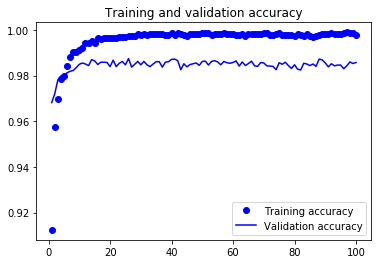

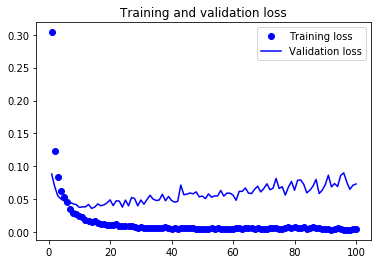

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
      path = test_dir +"/"+ random.choice(os.listdir(test_dir))
      
      #Get the Picture
      random_img = random.choice(os.listdir(path))
      img_path = os.path.join(path, random_img)
      img = image.load_img(img_path, target_size=(img_width, img_height))
      img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
      img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
      
      # Extract features
      features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))
      
      
      # Make prediction
      try:
          prediction = model.predict(features)
      except:
          prediction = model.predict(features.reshape(1, 7*7*512))
          
      # Show picture
      plt.imshow(img_tensor)
      plt.show()
      
      # Write prediction
      print(sorted(os.listdir(test_dir))[np.argmax(prediction)])
      
      

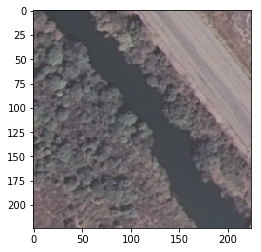

river


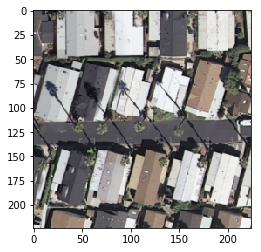

mobilehomepark


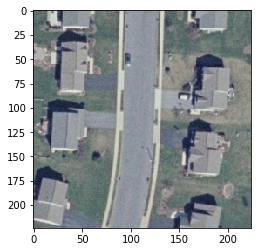

mediumresidential


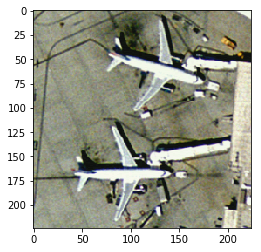

airplane


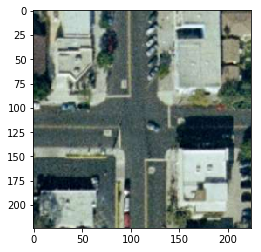

intersection


In [0]:
# Visualize predictions
visualize_predictions(model, 5)